### Introduction

This notebook creates a Sionna Scene (https://nvlabs.github.io/sionna/api/rt.html#scene) using openstreetmap. This can be used as an alternative to exporting scene from Blender (https://www.youtube.com/watch?v=7xHLDxUaQ7c).

In [1]:
# === Cell 1: Select a city or draw an ROI, and output REGION / ROI_COORDS_WGS84 / TARGET_EPSG ===

import ipyleaflet
import pyproj
import shapely
from shapely.geometry import shape
from shapely.ops import transform
import math
import pyvista as pv
import numpy as np
import osmnx as ox
from shapely.geometry import Polygon, Point, LineString
import os
from pyproj import Transformer
import open3d as o3d
import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom
import os

# -------------------- 10 selectable cities and their EPSG（WGS84 / UTM） --------------------
# Note: All are Northern Hemisphere UTM (EPSG:326xx), with high precision and in meters, suitable for geometric modeling/extrusion.
CITIES = {
    # Name: {Center Point (lat, lon), EPSG}
    "Shanghai":      {"center": (31.230416, 121.473701), "epsg": "EPSG:4528"},  # Shanghai ~ zone 51N
    "Beijing":       {"center": (39.904200, 116.407396), "epsg": "EPSG:4527"},  # Beijing ~ zone 50N
    "Tianjin":       {"center": (39.125596, 117.190186), "epsg": "EPSG:4528"},  # Tianjin ~ zone 50N
    "Hangzhou":      {"center": (30.274084, 120.155070), "epsg": "EPSG:4527"},  # Hangzhou ~ zone 51N
    "Shenzhen":      {"center": (22.543096, 114.057865), "epsg": "EPSG:4526"},  # Shenzhen ~ zone 50N
    "NewYork":  {"center": (40.7128, -74.0060),   "epsg": "EPSG:32118"}, 
    "London":  {"center": (51.5074, -0.1278),   "epsg": "EPSG:27700"}, 
    "Tokyo":  {"center": (35.6895, 139.6917),   "epsg": "EPSG:32654"}, 
    "Singapore":  {"center": (1.3521, 103.8198),   "epsg": "EPSG:3414"}, 
    "Berlin":  {"center": (52.5200, 13.4050),   "epsg": "EPSG:25833"}, 
    "Dubai":  {"center": (25.2048, 55.2708),   "epsg": "EPSG:32640"}, 
    "Nanjing":  {"center": (32.0603, 118.7969),   "epsg": "EPSG:4528"}, 
    "Sydney":  {"center": (-33.8688, 151.2093),   "epsg": "EPSG:4326"}, 
}

SELECTED_CITY = "Nanjing"
sub_scene_id = 2
# -------------------------------------------------------------------

os.environ["SUMO_HOME"] = "/usr/share/sumo"

# —— Inject the center point with the city table & EPSG —— #
center_lat, center_lon = CITIES[SELECTED_CITY]["center"]
LOCATION_STR = SELECTED_CITY
TARGET_EPSG = CITIES[SELECTED_CITY]["epsg"]   # e.g. "EPSG:32650"

# Set up default values for resolution
spp_default = 4096
resx_default = 1024
resy_default = 768

# Define camera settings
camera_settings = {
    "rotation": (0, 0, -90),  # Assuming Z-up orientation
    "fov": 90
}

transformer = Transformer.from_crs("EPSG:4326", TARGET_EPSG, always_xy=True)
center_proj = transformer.transform(center_lon, center_lat)  # Note Transformer(always_xy=True): input lon first, then lat
sionna_origin_x = center_proj[0]
sionna_origin_y = center_proj[1]
sionna_center_z = 0

m = ipyleaflet.Map(center=(center_lat, center_lon), zoom=16)

# Custom DrawControl: enable rectangle
dc = ipyleaflet.DrawControl(
    rectangle={
        "shapeOptions": {
            "color": "#ff7800",
            "weight": 1
        }
    },
    polygon={},
    polyline={},
    circlemarker={},  # Optional: disable other shapes
    circle={},        # Optional: disable circle
    marker={}         # Optional: disable marker
)

m.add(dc)
m


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Map(center=[32.0603, 118.7969], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

ha=100*100m^2 (Generally, 4ha is captured, which is the area within the range of 200x200m)

#### Initialize Sionna Scene XML object and add defaults

### Open Interactive map to select Region to be used

Use controls on the map to draw a region of any shape.

In [ ]:
import os
from pathlib import Path
import numpy as np
import pyproj
import pyvista as pv
import osmnx as ox
import xml.etree.ElementTree as ET
from xml.dom import minidom
from shapely.geometry import Polygon, shape, Point
import shapely
import open3d as o3d
import warnings

# ============================ Adjustable Parameters ============================
NUM_SCENES = 50
SCENE_PREFIX = "scene"

BEGIN_TIME = 0
END_TIME   = 9              
ALT_MIN, ALT_MAX = 60.0, 80.0
ALT_MODE = "sin"              # "sin" or "rw"
ALT_PERIOD_STEPS = 60
RW_STEP_SIGMA = 1.0
RW_SMOOTH_WINDOW = 9

RANDOM_SEED = None
# RANDOM_SEED = 2025

# Materials
ITU_MATS = ["marble", "concrete", "metal", "medium_dry_ground"]

# Default building floor height (m)
FLOOR_HEIGHT = 3.5
DEFAULT_BUILDING_HEIGHT = 21.0

warnings.filterwarnings("ignore", category=UserWarning)

# ============================ Coordinate Tools ============================
class SceneCS_OSM:
    """
      - ROI is first projected to EPSG:3414
      - The origin is set at the midpoint of the top edge of the ROI's bounding rectangle in EPSG:3414
      - Scene coordinate transformation: X = origin_y - y3414, Y = x3414 - origin_x
    """
    def __init__(self, roi_ll_wgs84):
        wgs84 = pyproj.CRS("epsg:4326")
        epsg3414 = pyproj.CRS("epsg:3414")
        self.to3414 = pyproj.Transformer.from_crs(wgs84, epsg3414, always_xy=True)

        ll = roi_ll_wgs84[:]
        if ll[0] != ll[-1]:
            ll.append(ll[0])

        self.roi_3414 = [self.to3414.transform(lon, lat) for lon, lat in ll]
        self.roi_poly_3414 = Polygon(self.roi_3414)

        minx, miny, maxx, maxy = self.roi_poly_3414.bounds
        self.origin_x = 0.5 * (minx + maxx)  
        self.origin_y = maxy                

    def wgs84_to_3414(self, lon, lat):
        return self.to3414.transform(lon, lat)

    def _3414_to_scene_xy(self, x3414, y3414):
        return (self.origin_y - y3414, x3414 - self.origin_x)

# ============================ Basic Geometry → PLY + Sionna XML Fragments ============================
def tri_save_poly(scene_xy_ring, z, ply_path):
    faces = [len(scene_xy_ring), *range(len(scene_xy_ring))]
    poly = pv.PolyData([p + (z,) for p in scene_xy_ring], faces=faces)
    mesh = poly.delaunay_2d()
    mesh.save(ply_path)
    o3d.io.write_triangle_mesh(str(ply_path), o3d.io.read_triangle_mesh(str(ply_path)))

def extrude_prism(scene_xy_ring, z0, height, ply_path):
    faces = [len(scene_xy_ring), *range(len(scene_xy_ring))]
    base = pv.PolyData([p + (z0,) for p in scene_xy_ring], faces=faces)
    mesh = base.delaunay_2d().triangulate().extrude((0, 0, height), capping=False)
    mesh.save(ply_path)
    o3d.io.write_triangle_mesh(str(ply_path), o3d.io.read_triangle_mesh(str(ply_path)))

def box_mesh(center, size_xyz, ply_path):
    cx, cy, cz = center
    lx, ly, lz = size_xyz
    x0, x1 = cx - lx/2, cx + lx/2
    y0, y1 = cy - ly/2, cy + ly/2
    z0, z1 = cz - lz/2, cz + lz/2
    box = pv.Box(bounds=(x0, x1, y0, y1, z0, z1))
    box.save(ply_path)
    o3d.io.write_triangle_mesh(str(ply_path), o3d.io.read_triangle_mesh(str(ply_path)))

def xml_add_shape(scene_xml_root, ply_path, mat_id, shape_id):
    s = ET.SubElement(scene_xml_root, "shape", type="ply", id=shape_id)
    ET.SubElement(s, "string", name="filename", value=str(ply_path))
    ET.SubElement(s, "ref", id=mat_id, name="bsdf")
    ET.SubElement(s, "boolean", name="face_normals", value="true")
    return s

def make_scene_xml(spp=64, resx=512, resy=512):
    scene = ET.Element("scene", version="2.1.0")
    for k, v in (("spp", str(spp)), ("resx", str(resx)), ("resy", str(resy))):
        ET.SubElement(scene, "default", name=k, value=v)
    ET.SubElement(scene, "integrator", type="path")
    ET.SubElement(scene, "emitter", type="constant", id="World")
    for mat in ITU_MATS:
        bsdf = ET.SubElement(scene, "bsdf", type="itu-radio-material", id=f"mat-itu_{mat}")
        ET.SubElement(bsdf, "string", name="material_type", value=mat)
    return scene

# ============================ UAV Altitude Trajectory ============================
def gen_altitude_sin(N, zmin, zmax, period_steps=None, rng=None):
    center = 0.5*(zmin+zmax); amp = 0.5*(zmax-zmin)
    if not period_steps or period_steps <= 1:
        period_steps = N
    k = 2*np.pi/float(period_steps)
    phi = rng.uniform(0.0, 2.0*np.pi) if rng is not None else 0.0
    n = np.arange(N, dtype=float)
    return center + amp*np.sin(k*n + phi)

def gen_altitude_rw(N, zmin, zmax, step_sigma, smooth_win, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    steps = rng.normal(0.0, step_sigma, size=N)
    z = np.cumsum(steps)
    z = (z - z.min()) / max(1e-6, (z.max() - z.min()))
    z = zmin + z * (zmax - zmin)
    w = int(smooth_win); w = w+1 if w % 2 == 0 else w
    if w > 1:
        kernel = np.ones(w) / w
        z = np.convolve(z, kernel, mode="same")
    return np.clip(z, zmin, zmax)

# ============================ Simple Random Tools (Global RNG) ============================
_GLOBAL_RNG = np.random.default_rng(RANDOM_SEED)

def _rand_point_in_roi(poly_3414, rng):
    """Uniformly sample within the bounding rectangle of the ROI (3414), reject samples until the point falls inside the polygon."""
    minx, miny, maxx, maxy = poly_3414.bounds
    for _ in range(10000):
        x = rng.uniform(minx, maxx)
        y = rng.uniform(miny, maxy)
        if poly_3414.contains(Point(x, y)):
            return x, y
    return 0.5*(minx+maxx), maxy

def sample_xy_line_in_roi(poly_3414, rng, min_span=10.0):
    """Randomly sample two points to generate a straight line; only ensure the endpoints are not too close."""
    for _ in range(1000):
        x1, y1 = _rand_point_in_roi(poly_3414, rng)
        x2, y2 = _rand_point_in_roi(poly_3414, rng)
        if np.hypot(x2-x1, y2-y1) >= min_span:
            return x1, y1, x2, y2

    return _rand_point_in_roi(poly_3414, rng)[0], _rand_point_in_roi(poly_3414, rng)[1], \
           _rand_point_in_roi(poly_3414, rng)[0], _rand_point_in_roi(poly_3414, rng)[1]

# ============================ Main Process ============================
def build_all_scenes(coords_wgs84,index):
    """
    coords_wgs84: ROI polygon coordinates in WGS84 (longitude, latitude), e.g.:
        coords_wgs84 = [[lon1, lat1], [lon2, lat2], ..., [lon1, lat1]]
    """
    cs = SceneCS_OSM(coords_wgs84)
    outer_dir = Path("DownstreamDataset/OriginalOSM_Train/Suburban/Nanjing"); outer_dir.mkdir(parents=True, exist_ok=True)

    # Main directory name: use the integer coordinates of the midpoint of the top edge of the ROI bounding rectangle (EPSG:3414)
    cx_i, cy_i = int(cs.origin_x), int(cs.origin_y)
    MAIN_DIR = outer_dir / f"scene_{index}"
    MAIN_DIR.mkdir(parents=True, exist_ok=True)

    # Pre-fetch buildings (WGS84)
    roi_poly_wgs84 = Polygon(coords_wgs84)
    try:
        buildings = ox.features_from_polygon(roi_poly_wgs84, tags={"building": True})
    except Exception:
        buildings = None

    # Per sub-scene: XY trajectory = random line within ROI (no deduplication/reversal/gridding)
    for i in range(1, NUM_SCENES + 1):
        scene_id   = f"{SCENE_PREFIX}_{i:03d}"
        SCENE_DIR  = MAIN_DIR / scene_id
        TIMES_ROOT = SCENE_DIR / "times"
        SCENE_DIR.mkdir(parents=True, exist_ok=True)
        TIMES_ROOT.mkdir(parents=True, exist_ok=True)

        x1, y1, x2, y2 = sample_xy_line_in_roi(cs.roi_poly_3414, _GLOBAL_RNG, min_span=10.0)

        times = np.arange(BEGIN_TIME, END_TIME + 1, 1.0)
        N_frames = len(times)

        rng_traj = _GLOBAL_RNG

        a = rng_traj.uniform(0.8, 1.2)
        b = rng_traj.uniform(0.8, 1.2)
        t_lin = np.linspace(0.0, 1.0, N_frames)
        alpha = (t_lin**a) / (t_lin**a + (1.0 - t_lin)**b + 1e-12)

        # Altitude trajectory
        if ALT_MODE.lower() == "rw":
            z_traj = gen_altitude_rw(N_frames, ALT_MIN, ALT_MAX, RW_STEP_SIGMA, RW_SMOOTH_WINDOW, rng=rng_traj)
        else:
            per_steps = int(np.clip(
                rng_traj.normal(ALT_PERIOD_STEPS, ALT_PERIOD_STEPS*0.15),
                ALT_PERIOD_STEPS*0.6, ALT_PERIOD_STEPS*1.4
            ))
            z_traj = gen_altitude_sin(N_frames, ALT_MIN, ALT_MAX, period_steps=per_steps, rng=rng_traj)
            z_traj += rng_traj.normal(0.0, 0.3, size=N_frames)
            z_traj = np.clip(z_traj, ALT_MIN, ALT_MAX)

        # === Write Sionna scene for each frame ===
        for idx, (t, a_) in enumerate(zip(times, alpha)):
            x = x1 + (x2 - x1) * a_
            y = y1 + (y2 - y1) * a_
            Xs, Ys = cs._3414_to_scene_xy(x, y)
            Zs = float(z_traj[idx])

            time_dir = TIMES_ROOT / f"time_{idx:03d}_t{format(float(t), '.2f').replace('.', '_')}"
            mesh_dir = time_dir / "mesh"
            mesh_dir.mkdir(parents=True, exist_ok=True)

            # 1) Scene XML
            scene_xml = make_scene_xml(spp=64, resx=512, resy=512)

            # 2) Ground
            ground_ring_scene = [cs._3414_to_scene_xy(X, Y) for (X, Y) in cs.roi_poly_3414.exterior.coords]
            ground_ply = mesh_dir / "ground.ply"
            tri_save_poly(ground_ring_scene, z=0.0, ply_path=ground_ply)
            xml_add_shape(scene_xml, ground_ply, "mat-itu_medium_dry_ground", "mesh-ground")

            # 3) Buildings
            if (buildings is not None) and (not getattr(buildings, "empty", True)):
                try:
                    b3414 = buildings.to_crs("EPSG:3414")
                except Exception:
                    b3414 = None
                if b3414 is not None:
                    for bidx, rec in enumerate(b3414.itertuples(index=False)):
                        geom = rec.geometry
                        if geom.geom_type not in ["Polygon", "MultiPolygon"]:
                            continue
                        poly = shape(geom).intersection(cs.roi_poly_3414)
                        if poly.is_empty:
                            continue
                        polys = [poly] if poly.geom_type == "Polygon" else list(poly.geoms)

                        # Read number of floors
                        levels = None
                        for key in ["building:levels", "building_levels", "levels"]:
                            if hasattr(rec, key):
                                levels = getattr(rec, key)
                                if levels is not None:
                                    break
                        try:
                            height = float(levels) * FLOOR_HEIGHT if levels is not None else DEFAULT_BUILDING_HEIGHT
                        except Exception:
                            height = DEFAULT_BUILDING_HEIGHT

                        for si, p in enumerate(polys):
                            ring_3414 = list(p.exterior.coords)
                            base_scene = [cs._3414_to_scene_xy(X, Y) for (X, Y) in ring_3414]
                            if len(base_scene) < 3:
                                continue
                            wall_ply = mesh_dir / f"building_{bidx}_{si}_walls.ply"
                            extrude_prism(base_scene, z0=0.0, height=height, ply_path=wall_ply)
                            xml_add_shape(scene_xml, wall_ply, "mat-itu_marble", f"building_{bidx}_{si}_walls")

                            roof_ply = mesh_dir / f"building_{bidx}_{si}_roof.ply"
                            tri_save_poly(base_scene, z=height, ply_path=roof_ply)
                            xml_add_shape(scene_xml, roof_ply, "mat-itu_concrete", f"building_{bidx}_{si}_roof")

            # 4) UAV box
            uav_ply = mesh_dir / "uav.ply"
            box_mesh(center=(Xs, Ys, Zs), size_xyz=(0.1, 0.1, 0.1), ply_path=uav_ply)
            xml_add_shape(scene_xml, uav_ply, "mat-itu_metal", "uav")

            # 5) UE_uav_traj.xml (single point per frame, Scene coordinates)
            ue_root = ET.Element("trajectories")
            uav = ET.SubElement(ue_root, "uav", id="uav0")
            ET.SubElement(uav, "state", t=f"{float(t):.6f}",
                          x=f"{float(Xs):.6f}", y=f"{float(Ys):.6f}", z=f"{float(Zs):.6f}")
            ue_xml = minidom.parseString(ET.tostring(ue_root, encoding="utf-8")).toprettyxml(indent="    ")
            with open(time_dir / "UE_uav_traj.xml", "w", encoding="utf-8") as f:
                f.write(ue_xml)

            # 6) Write scene XML
            xml_pretty = minidom.parseString(ET.tostring(scene_xml, encoding="utf-8")).toprettyxml(indent="    ")
            with open(time_dir / "simple_OSM_scene.xml", "w", encoding="utf-8") as f:
                f.write(xml_pretty)

            print(f"✅ {scene_id} / {time_dir.name} generated (UAV z = {Zs:.2f} m)")

        print(f"✅ {scene_id}: Generated {len(times)} time points.")

    print(f"\n✅ All {NUM_SCENES} simulation scenes generated!")
    print(f"Main directory: {MAIN_DIR}")
    return MAIN_DIR

# =============== Usage example (replace coords_wgs84 as needed before running) ===============
coords_wgs84 = dc.last_draw['geometry']['coordinates'][0]
MAIN_DIR = build_all_scenes(coords_wgs84,sub_scene_id)


  · ✅ scene_001 / time_000_t0_00 generated (UAV z = 63.22 m)
  · ✅ scene_001 / time_001_t1_00 generated (UAV z = 61.92 m)
  · ✅ scene_001 / time_002_t2_00 generated (UAV z = 61.65 m)
  · ✅ scene_001 / time_003_t3_00 generated (UAV z = 61.68 m)
  · ✅ scene_001 / time_004_t4_00 generated (UAV z = 60.69 m)
  · ✅ scene_001 / time_005_t5_00 generated (UAV z = 60.35 m)
  · ✅ scene_001 / time_006_t6_00 generated (UAV z = 60.66 m)
  · ✅ scene_001 / time_007_t7_00 generated (UAV z = 60.26 m)
  · ✅ scene_001 / time_008_t8_00 generated (UAV z = 60.40 m)
  · ✅ scene_001 / time_009_t9_00 generated (UAV z = 60.21 m)
✅ scene_001: Generated 10 time points.
  · ✅ scene_002 / time_000_t0_00 generated (UAV z = 79.67 m)
  · ✅ scene_002 / time_001_t1_00 generated (UAV z = 79.41 m)
  · ✅ scene_002 / time_002_t2_00 generated (UAV z = 79.87 m)
  · ✅ scene_002 / time_003_t3_00 generated (UAV z = 80.00 m)
  · ✅ scene_002 / time_004_t4_00 generated (UAV z = 79.91 m)
  · ✅ scene_002 / time_005_t5_00 generated (UA

2025-11-13 20:26:01.626 (3333.446s) [    7A70C649A440]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=


Current frame: DownstreamDataset/OriginalOSM_Train/Suburban/Nanjing/scene_2/scene_001/times/time_000_t0_00
Number of trajectory points: 10, Height range: [60.21, 63.22] m
✅ Visualization image saved as DownstreamDataset/OriginalOSM_Train/Suburban/Nanjing/scene_2/scene_001/scene_image.png


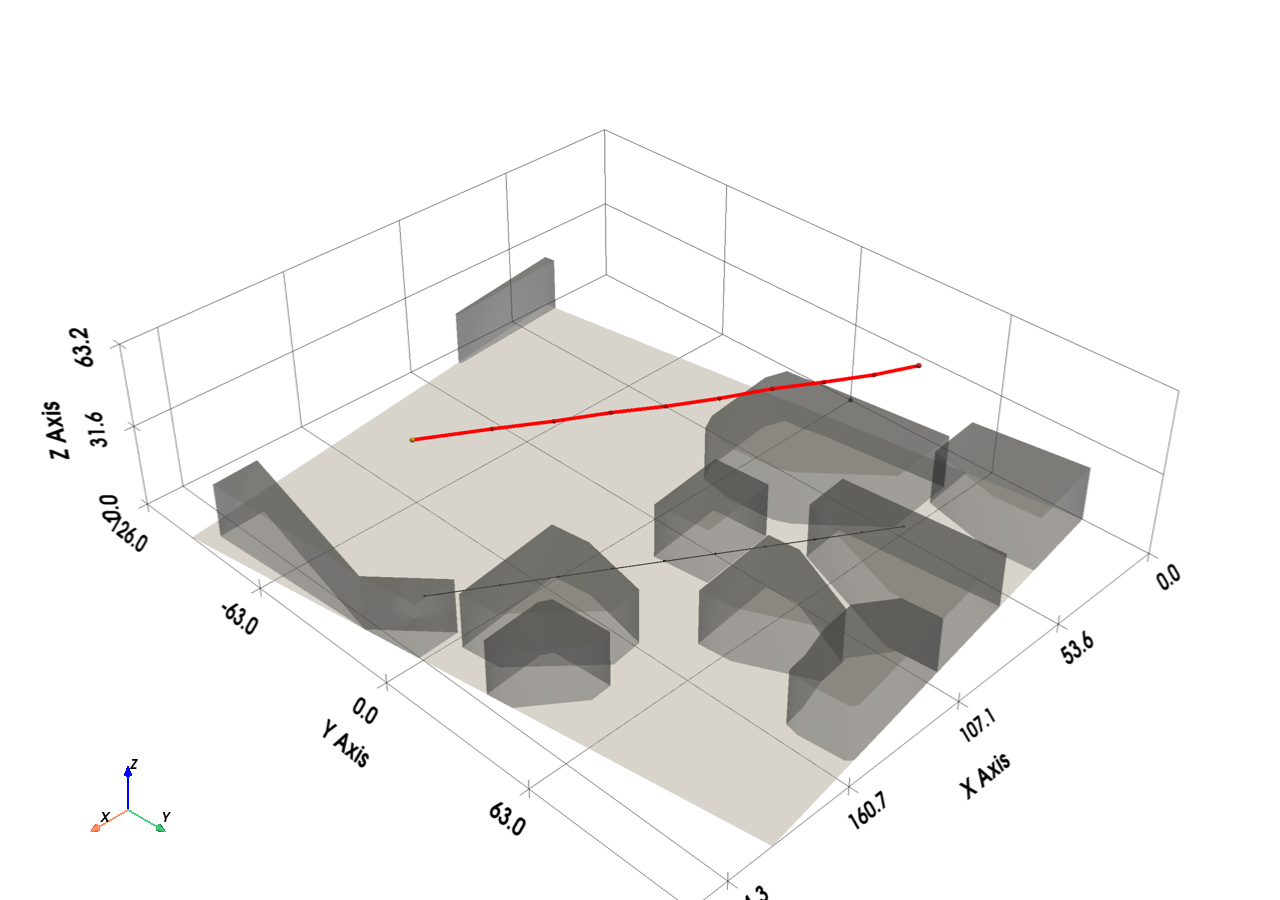

In [ ]:
import numpy as np
import pyvista as pv
import xml.etree.ElementTree as ET
from pathlib import Path
import re

# ===== Colors =====
COLOR_GROUND   = "#e0e0e0"
COLOR_WALL     = "#7d7d7d"
COLOR_ROOF     = "#555555"
COLOR_ROAD     = "#d49400"
COLOR_TRAJ2D   = "#000000"
COLOR_START    = "#e53935"
COLOR_END      = "#fbc02d"
COLOR_ORIGIN   = "#212121"

def visualize_scene(
    MAIN_SCENE_DIR: Path,
    TIME_DIR: Path | None = None,
    save_image: bool = False,
    image_path: str | Path = "scene_image.png"
):
    """
    Visualize a sub-scene (static environment + UAV trajectory), without relying on net.xml / SUMO coordinates.
    MAIN_SCENE_DIR: e.g., Dataset_LAE/scene_xxx/scene_001
    TIME_DIR: specify a frame directory (.../times/time_***), if not specified, the first frame is used
    """

    # --- PyVista white background theme ---
    pv.global_theme.background = "white"
    pv.global_theme.font.color = "black"
    pv.global_theme.edge_color = "black"

    if not MAIN_SCENE_DIR.exists():
        raise FileNotFoundError(f"Main scene directory does not exist: {MAIN_SCENE_DIR}")

    # Find time directories
    def list_time_dirs(main_scene_dir: Path):
        times_root = main_scene_dir / "times"
        if not times_root.exists():
            raise FileNotFoundError(f"Times directory not found: {times_root}")
        items = []
        for td in sorted(times_root.glob("time_*")):
            t_val = None
            traj3d = td / "UE_uav_traj.xml"
            if traj3d.exists():
                try:
                    root = ET.parse(traj3d).getroot()
                    st = root.find(".//state")
                    if st is not None and "t" in st.attrib:
                        t_val = float(st.attrib["t"])
                except Exception:
                    t_val = None
            if t_val is None:
                m = re.search(r"_t([\d_]+)$", td.name)
                t_val = float(m.group(1).replace("_", ".")) if m else 0.0
            items.append((t_val, td))
        items.sort(key=lambda x: x[0])
        return [td for _, td in items]

    t_dirs = list_time_dirs(MAIN_SCENE_DIR)
    if not t_dirs:
        raise FileNotFoundError(f"No frames found under {MAIN_SCENE_DIR}/times")
    current_time_dir = Path(TIME_DIR) if TIME_DIR else t_dirs[0]
    if not current_time_dir.exists():
        raise FileNotFoundError(f"Specified TIME_DIR does not exist: {current_time_dir}")

    # Read UAV trajectories at all times
    def read_xyz_from_traj3d(traj3d_path: Path):
        root = ET.parse(traj3d_path).getroot()
        st = root.find(".//state")
        if st is None:
            raise ValueError(f"{traj3d_path} does not have a <state> node")
        x = float(st.attrib["x"]); y = float(st.attrib["y"]); z = float(st.attrib["z"])
        t = float(st.attrib.get("t", "0"))
        return x, y, z, t

    records = []
    for td in t_dirs:
        traj3d = td / "UE_uav_traj.xml"
        if not traj3d.exists():
            continue
        try:
            x, y, z, t = read_xyz_from_traj3d(traj3d)
            records.append((x, y, z))
        except Exception:
            continue
    if not records:
        raise RuntimeError("Failed to collect any trajectory points.")
    pts = np.array(records, dtype=float)

    # Read current frame mesh
    mesh_dir = current_time_dir / "mesh"
    if not mesh_dir.exists():
        raise FileNotFoundError(f"Current frame mesh directory does not exist: {mesh_dir}")

    def classify_mesh(nm: str):
        if nm == "ground.ply": return "ground"
        if re.match(r"^building_.*_walls\.ply$", nm): return "building_walls"
        if re.match(r"^building_.*_roof\.ply$", nm):  return "building_roof"
        if nm == "uav.ply" or re.match(r"^uav_.*\.ply$", nm): return "uav"
        return "others"

    ground_mesh = None
    building_walls, building_roofs, uav_meshes = [], [], []
    for ply in sorted(mesh_dir.glob("*.ply")):
        cls = classify_mesh(ply.name)
        m = pv.read(ply)
        if m.n_points == 0 or m.n_cells == 0:
            continue
        if cls == "ground":
            ground_mesh = m.copy()
        elif cls == "building_walls":
            building_walls.append(m)
        elif cls == "building_roof":
            building_roofs.append(m)
        elif cls == "uav":
            uav_meshes.append(m)

    # Plot
    plotter = pv.Plotter(window_size=(1280, 900))
    plotter.enable_anti_aliasing()
    plotter.add_axes(line_width=2)

    # Ground
    if ground_mesh is not None:
        plotter.add_mesh(ground_mesh, color=COLOR_GROUND, opacity=0.7, smooth_shading=True)

    # Buildings
    for m in building_walls:
        plotter.add_mesh(m, color=COLOR_WALL, opacity=0.35, smooth_shading=True)
    for m in building_roofs:
        plotter.add_mesh(m, color=COLOR_ROOF, opacity=0.55, smooth_shading=True)

    # UAV trajectory (3D line + ground projection + endpoints)
    if len(pts) >= 2:
        cells = np.insert(np.arange(len(pts), dtype=np.int64), 0, len(pts))
        poly3d = pv.PolyData(pts); poly3d.lines = cells
        plotter.add_mesh(poly3d, color="red", line_width=8.0, render_lines_as_tubes=False)
        # Ground projection
        pts2d = pts.copy(); pts2d[:, 2] = 0.05
        poly2d = pv.PolyData(pts2d); poly2d.lines = cells
        plotter.add_mesh(poly2d, color=COLOR_TRAJ2D, line_width=2.0, render_lines_as_tubes=False)
        plotter.add_points(pts, color="red", point_size=10, render_points_as_spheres=True)

    # Start/End/Origin
    plotter.add_points(pts[0:1], color=COLOR_START, point_size=12, render_points_as_spheres=True)
    plotter.add_points(pts[-1:], color=COLOR_END, point_size=12, render_points_as_spheres=True)
    plotter.add_points(np.array([[0.0, 0.0, 0.0]]), color=COLOR_ORIGIN, point_size=10, render_points_as_spheres=True)

    # Camera and bounds
    plotter.show_bounds(grid='back', location='outer', ticks='both',
                        n_xlabels=5, n_ylabels=5, n_zlabels=3, color="black")
    plotter.camera_position = 'iso'
    plotter.reset_camera(); plotter.camera.zoom(1.2)

    print(f"Current frame: {current_time_dir}")
    print(f"Number of trajectory points: {len(pts)}, Height range: [{pts[:,2].min():.2f}, {pts[:,2].max():.2f}] m")

    if save_image:
        plotter.screenshot(str(image_path))
        print(f"✅ Visualization image saved as {image_path}")

    plotter.show()
    
visualize_scene(
    MAIN_SCENE_DIR = MAIN_DIR / "scene_001",
    TIME_DIR = None,
    save_image = True,
    image_path = MAIN_DIR / "scene_001/scene_image.png"
)


without trajectory visualization: